In [287]:
import csv
import os
import tensorflow as tf
import keras
from keras import layers, models
import sklearn.model_selection
import numpy as np
import math

tf.config.set_visible_devices([], 'GPU')


In [288]:

user_data = csv.DictReader(open('u.csv', encoding='utf8'))

activity_destination_pairs = []
for row in user_data:
    activities = eval(row['Preferred Activities'])
    activities = list(map(lambda activity: activity.strip(), activities))

    destinations = eval(row['Bucket list destinations Sri Lanka'])
    destinations = list(map(lambda destination: destination.strip(), destinations))

    activity_destination_pairs.append((activities, destinations))

# activity_destination_pairs = activity_destination_pairs[:10]
train_dataset, test_dataset = sklearn.model_selection.train_test_split(activity_destination_pairs, test_size=0.10)

unique_activities = list(set([activity for activities, _ in activity_destination_pairs for activity in activities]))
unique_activities.sort()

unique_destinations = list(set([destination for _, destinations in activity_destination_pairs for destination in destinations]))
unique_destinations.sort()

print(len(activity_destination_pairs), len(unique_activities), len(unique_destinations))


10000 68 157


In [289]:
review_scores_data = csv.DictReader(open('review_scores.csv', encoding='utf8'))

review_scores = {}
for row in review_scores_data:
    place_name = row['name'].strip()
    scores = eval(row['scores'])
    review_scores[place_name] = sum(scores)/len(scores)

place_data = csv.DictReader(open('p.csv', encoding='utf8'))

place_ratings = {}
for row in place_data:
    place_name = row['name'].strip()
    if not (row['rating'] and row['user_ratings_total']):
        continue

    rating = float(row['rating'])
    total_ratings = int(row['user_ratings_total'])
    review_score = review_scores.get(place_name, 1)

    adjusted_ratings = math.log10(total_ratings)
    place_ratings[place_name] = math.log(rating * adjusted_ratings)*review_score

average_rating = sum(place_ratings.values()) / len(place_ratings)
print(len(place_ratings), average_rating, min(place_ratings.values()), max(place_ratings.values()))

place_score_array = np.array([place_ratings[place] if place in place_ratings else average_rating for place in unique_destinations]) + 1
place_score_array = place_score_array / max(place_score_array)


343 2.3559718959104163 0.0014442199338873952 3.0539323957792286


In [290]:

place_score_array = np.array([place_ratings[place] if place in place_ratings else average_rating for place in unique_destinations]) + 1
place_score_array = place_score_array / max(place_score_array)


In [291]:

class PlaceScoreLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PlaceScoreLayer, self).__init__()

    def build(self, input_shape):
        self.scores = self.add_weight("scores", shape=[int(input_shape[-1]),])

    def call(self, inputs):
        return inputs*self.scores


model = keras.Sequential([
    layers.Input(shape=(len(unique_activities),)),
    layers.Dense(units=len(unique_destinations), use_bias=False, kernel_initializer='zeros'),
    PlaceScoreLayer(),
])

model.summary()


Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_46 (Dense)            (None, 157)               10676     
                                                                 
 place_score_layer_21 (Place  (None, 157)              157       
 ScoreLayer)                                                     
                                                                 
Total params: 10,833
Trainable params: 10,833
Non-trainable params: 0
_________________________________________________________________


In [292]:

weights = model.get_weights()
weights[0][:, :] = 0

for activities, destinations in train_dataset:
    for activity in activities:
        for destination in destinations:
            weights[0][unique_activities.index(activity)][unique_destinations.index(destination)] += 1

weights[0] = sklearn.preprocessing.minmax_scale(weights[0], axis=1)
weights[1] = place_score_array

model.set_weights(weights)
# print(model.get_weights())


In [293]:
def predict_top_5_destinations(activities_list):
    activity_vector = [1 if activity in activities_list else 0 for activity in unique_activities]
    output = model.call(inputs=tf.convert_to_tensor([activity_vector]))
    top_predictions = tf.math.top_k(output, k=5)

    prediction_scores = top_predictions.values.numpy().tolist()[0]
    top_indices = top_predictions.indices.numpy().tolist()[0]

    prediction_scores = list(filter(lambda x: x > .5, prediction_scores))
    top_destinations = [unique_destinations[idx] for idx in top_indices[:len(prediction_scores)]]

    return top_destinations, prediction_scores


def refined_top_5_destinations(input_data):
    activity_1, activity_2, activity_3 = input_data
    initial_predictions, initial_scores = predict_top_5_destinations([activity_1, activity_2, activity_3])
    return initial_predictions, initial_scores

    for single_activity in [activity_3, activity_2, activity_1]:
        refined_predictions, refined_scores = predict_top_5_destinations([single_activity])
        if len(refined_predictions) == 0:
            continue
        top_prediction, top_score = refined_predictions[0], refined_scores[0]

        if top_prediction not in initial_predictions:
            initial_predictions.insert(0, top_prediction)
            initial_scores.insert(0, top_score)

    return initial_predictions[:5], initial_scores[:5]


In [294]:
def predict_and_print(activities):
    if len(activities) == 1:
        predictions = predict_top_5_destinations(activities)
    else:
        predictions = refined_top_5_destinations(activities)

    print(', '.join(activities), dict(zip(predictions[0], map(lambda score: round(score, 2), predictions[1]))))


predict_and_print(['hot springs'])
predict_and_print(['elephant rides'])
predict_and_print(['museum visits'])
predict_and_print(['waterfalls'])
predict_and_print(['hot springs', 'elephant rides', 'waterfalls'])
predict_and_print(['cycling', 'historical monuments', 'village homestays'])


hot springs {'Madunagala Hot Water Spring': 0.89, 'Kanniya Hot Springs': 0.8, 'Maha Oya Hot Water Springs': 0.8, 'Mahapelessa Hot Springs': 0.78}
elephant rides {'Pinnawala': 0.83, 'Udawalawe': 0.81}
museum visits {'Colombo National Museum': 0.82, 'Kandy National Museum': 0.81, 'National Museum Galle': 0.79, 'Ratnapura Gem Museum': 0.79, 'Folk Museum': 0.75}
waterfalls {'Diyaluma Falls': 0.87, "St Clair's Falls": 0.83, 'Bopath Falls': 0.82, 'Bambarakiri Ella': 0.79, 'Bambarakanda Falls': 0.77}
hot springs, elephant rides, waterfalls {'Madunagala Hot Water Spring': 0.95, 'Diyaluma Falls': 0.9, 'Pinnawala': 0.87, 'Maha Oya Hot Water Springs': 0.87, 'Udawalawe': 0.87}
cycling, historical monuments, village homestays {'Ella': 1.67, 'Anuradhapura': 1.08, 'Hatton': 0.94, 'Haputale': 0.94, 'Polonnaruwa': 0.86}


In [295]:
from sklearn.metrics import accuracy_score
import numpy as np

true_labels = []
predicted_labels = []

for activities, destinations in test_dataset:
    top_predictions, _ = refined_top_5_destinations(activities)

    predicted_array = np.zeros(len(destinations), dtype=int)
    for idx, destination in enumerate(destinations):
        if destination in top_predictions:
            predicted_array[idx] = 1

    true_array = np.zeros(len(destinations), dtype=int)
    for idx, destination in enumerate(destinations):
        true_array[idx] = 1

    true_labels.extend(true_array)
    predicted_labels.extend(predicted_array)

accuracy = accuracy_score(true_labels, predicted_labels)

percentage_accuracy = accuracy * 100
print(percentage_accuracy)


50.12004801920769


                                              precision    recall  f1-score   support

                                    Ahangama       1.00      0.00      0.00        19
                                   Ahungalla       0.00      0.00      1.00         9
                                 Ambalangoda       0.85      0.48      0.61        23
                   Ambalangoda Mask Workshop       1.00      0.00      0.00        19
                            Ambuluwawa Tower       0.00      0.00      1.00        14
                       Anawilundawa Wetlands       1.00      0.00      0.00        15
                                 Anuradapura       0.50      0.30      0.37        20
                                Anuradhapura       0.56      0.72      0.63        92
                  Arankelle Forest Monastery       1.00      0.00      0.00        21
                            Arugam Bay Beach       1.00      0.00      0.00        23
                               Baker's Falls       1.

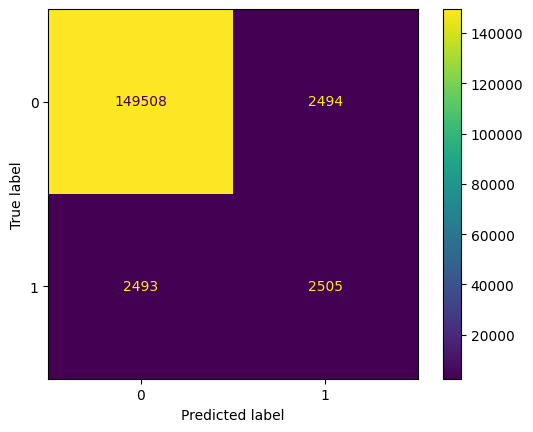

In [296]:
import tqdm
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []
for activities, destinations in test_dataset:
    top_predictions, _ = refined_top_5_destinations(activities)

    true_labels = [1 if x in destinations else 0 for x in unique_destinations]
    pred_labels = [1 if x in top_predictions else 0 for x in unique_destinations]

    y_true.append(true_labels)
    y_pred.append(pred_labels)

print(classification_report(y_true, y_pred, target_names=unique_destinations, zero_division=1))

cm = confusion_matrix(list(np.array(y_true).flat), list(np.array(y_pred).flat))
ConfusionMatrixDisplay(confusion_matrix=cm).plot()
